<a href="https://colab.research.google.com/github/Monoxido45/Active_learning_tests/blob/master/modules/reg_ativa_dados_reais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparando nosso metodo com os demais em dados reais

In [1]:
# pacotes importados
import numpy as np
import pandas as pd

# para os graficos
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
# instalando modAL
!pip install modAL
import modAL

# funcoes do sklearn e modal que serao usadas
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from modAL.models import CommitteeRegressor
from modAL.disagreement import max_std_sampling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Lasso
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
from modAL import ActiveLearner

sns.set_palette("Set1")

# montando o colab
from google.colab import drive
drive.mount('/content/drive')
images_dir = '/content/drive/MyDrive/Colab Notebooks/active_learning/figuras'

Mounted at /content/drive


## Funções dos métodos de AL, laço da modelagem e preparo do treino

In [2]:
# metodos para o AL
def bias_reduction(regressor, X, valid_regressor = KNeighborsRegressor(), k = 2, random_state = 99):
  # splitting into two folds:
  kf = KFold(n_splits = k, random_state = random_state, shuffle = True)
  # obtaining labeled data by regressor
  X_labeled, y_labeled = regressor.X_training, regressor.y_training

  errors = np.zeros((X.shape[0], k))
  # K-fold loop
  i = 0
  for train_idx, test_idx in kf.split(X_labeled):
    X_train, X_test = X_labeled[train_idx], X_labeled[test_idx]
    y_train, y_test = y_labeled[train_idx], y_labeled[test_idx]
    # first, fitting the current training data
    # cloning regressor
    # caso de comite
    if type(regressor.estimator) == modAL.models.learners.CommitteeRegressor:
      train_learner = regressor.estimator
      train_learner.teach(X_train, y_train, only_new = True)
    else:
      train_learner = clone(regressor.estimator)
      train_learner.fit(X = X_train, y = y_train)

    # now obtaining Z
    z = (y_test - train_learner.predict(X_test))**2

    # fitting the regression on z
    valid_learner = clone(valid_regressor)
    valid_learner.fit(X = X_test, y = z)

    # now obtaining the errors for each observation in the pool
    errors[:, i] = valid_learner.predict(X)
    i += 1
  
  # obtaining scores by computing the row-wise means of errors
  scores = errors.mean(axis=1)

  # sorting index in descending order
  ranked = np.argsort(scores)
  query_idx = ranked[::-1][0]

  # finally returning the index
  return query_idx, X[query_idx]


# definindo uma estrategia aleatoria
def random_sampling(regressor, X_pool):
  n_samples = len(X_pool)
  query_idx = np.random.choice(range(n_samples))
  return query_idx, X_pool[query_idx]

# definindo o uncertainty sampling para regressao
def uncertainty_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]


# laco da modelagem
def laco_modelo(n_queries, modelo, X_pool, y_pool, X_test, y_test, 
                trace = False, col = None, s = None, index = None, **fit_kwargs):
  list_mse = [mean_squared_error(y_test, modelo.predict(X_test))]
  X_pool_c, y_pool_c = np.copy(X_pool), np.copy(y_pool)

  # lasso do aprendizado ativo:
  for i in range(n_queries):
    query_idx, query_instance = modelo.query(X_pool_c, **fit_kwargs)
    X_sel, y_sel = X_pool_c[query_idx].reshape(1, -1), y_pool_c[query_idx].reshape(1, )
    modelo.teach(X = X_sel, y = y_sel)
    X_pool_c, y_pool_c = np.delete(X_pool_c, query_idx, axis=0), np.delete(y_pool_c, query_idx)
    if (trace):
      col[index[query_idx]] = 'green'
      s[index[query_idx]] = 50
      index = np.delete(index, query_idx)
    list_mse.append(mean_squared_error(y_test, modelo.predict(X_test)))
  if (trace):
    return [list_mse, col, s]
  return list_mse

def gera_semente(seed = 650, reps = 10):
  np.random.seed(seed)
  return(np.random.choice(np.arange(0, 1000), reps))

def prepare_train(X_pool, y_pool, n_initial = 10, colorize = False, seed = 700):
  X_pool_c, y_pool_c = np.copy(X_pool), np.copy(y_pool)
  np.random.seed(seed)
  # amostrando aleatoriamente sem reposicao
  train_idx = np.random.choice(range(X_pool_c.shape[0]),
    size = n_initial, replace = False)
  X_train = X_pool_c[train_idx]
  y_train = y_pool_c[train_idx]
  dict_al = {}
  if colorize:
    s = []
    col = []
    index = np.arange(0, X_pool_c.shape[0])
    for i in range(0, X_pool_c.shape[0]):
      if i in train_idx:
        col.append('red')
        s.append(50)
      else:
        col.append('black')
        s.append(20)
    index = np.delete(index, train_idx)
    dict_al = {"size" : s, "color" : col,"index" : index}

  # reduzindo a pool
  X_pool_c = np.delete(X_pool_c, train_idx, axis=0)
  y_pool_c = np.delete(y_pool_c, train_idx)
  dict_al["X_pool"], dict_al["y_pool"] = X_pool_c, y_pool_c
  dict_al["X_train"], dict_al["y_train"] = X_train, y_train
  return(dict_al)

## Dados de aerofólio

In [3]:
# lendo os dados
# dados de treinamento
airfoil_data = np.loadtxt('/content/drive/My Drive/Colab Notebooks/active_learning/airfoil_self_noise.dat', unpack = True)
airfoil_data = airfoil_data.transpose()
airfoil_data

array([[8.00000e+02, 0.00000e+00, 3.04800e-01, 7.13000e+01, 2.66337e-03,
        1.26201e+02],
       [1.00000e+03, 0.00000e+00, 3.04800e-01, 7.13000e+01, 2.66337e-03,
        1.25201e+02],
       [1.25000e+03, 0.00000e+00, 3.04800e-01, 7.13000e+01, 2.66337e-03,
        1.25951e+02],
       ...,
       [4.00000e+03, 1.56000e+01, 1.01600e-01, 3.96000e+01, 5.28487e-02,
        1.06604e+02],
       [5.00000e+03, 1.56000e+01, 1.01600e-01, 3.96000e+01, 5.28487e-02,
        1.06224e+02],
       [6.30000e+03, 1.56000e+01, 1.01600e-01, 3.96000e+01, 5.28487e-02,
        1.04204e+02]])

In [4]:
# dimensoes
airfoil_data.shape

(1503, 6)

Boxplot da resposta:

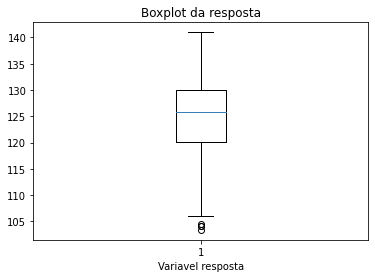

In [5]:
plt.boxplot(x = airfoil_data[:, 5])
plt.title("Boxplot da resposta")
plt.xlabel("Variavel resposta")
plt.show()

Separando em pool e teste:

In [6]:
X_pool_air, X_test_air, y_pool_air, y_test_air = train_test_split(np.delete(airfoil_data, 5, 1), 
                                                                  airfoil_data[:, 5],
                                                                  test_size = 0.2, 
                                                                  random_state=42)

Padronizando todos os dados menos a resposta:

In [7]:
from sklearn.preprocessing import StandardScaler

numeric_transformer = StandardScaler()
X_pool_air = numeric_transformer.fit_transform(X_pool_air)
X_test_air = numeric_transformer.transform(X_test_air)

Agora que definimos a pool e os dados de teste, iremos primeiramente comparar nosso metodo com o uncertainty sampling

### Bias reduction versus uncertainty sampling:

Definindo primeiramente a função para computar tudo:

In [14]:
# funcao que computa o mse
def mse_comp(n_queries, X_train, y_train, X_pool, y_pool,
             X_test, y_test, regressor, our_methods, other_method):
  all_methods = our_methods + other_method
  dici_mse = dict()
  model_list = []
  str1 = ''.join([c for c in str(regressor) if c.isupper()])
  reg_mod_random = ActiveLearner(estimator = regressor,
                     query_strategy = random_sampling,
                     X_training = X_train, y_training = y_train)
  
  list_rand = laco_modelo(n_queries, reg_mod_random, 
                          X_pool, y_pool, X_test, y_test)
  dici_mse[str1 + " " + "Random"] = list_rand
  
  for method in all_methods:
    if method in our_methods:
      reg_mod = ActiveLearner(estimator = regressor,
                     query_strategy = bias_reduction,
                     X_training = X_train, y_training = y_train)
      
      list_mse = laco_modelo(n_queries, reg_mod, 
                          X_pool, y_pool, X_test, y_test, 
                          valid_regressor = method)
      # string da combinacao
      str2 = ''.join([c for c in str(method) if c.isupper()])
    else:
      reg_mod = ActiveLearner(estimator = regressor,
                     query_strategy = method,
                     X_training = X_train, y_training = y_train)
      list_mse = laco_modelo(n_queries, reg_mod, 
                          X_pool, y_pool, X_test, y_test)
      
      # string da combinacao
      str2 = ''.join(["Outro"])
    dici_mse[str1 + " " + str2] = list_mse
  return(dici_mse)

# creando sim data
def create_sim_data(dici_mods):
  create = True
  for key in dici_mods.keys():
    mod_string = key.split(" ")
    if mod_string[1] == 'Random':
      if create:
        df_final = pd.DataFrame({"score" : np.tile(dici_mods[key], 3),
                      "consulta" : np.tile(np.arange(0, len(dici_mods[key])), 3),
                      "ajuste" : np.tile(mod_string[0], 3*len(dici_mods[key])),
                      "metodo": np.tile("Random", 3*len(dici_mods[key]))}
                    )
        create = False
      else:
        df_temp = pd.DataFrame({"score" : np.tile(dici_mods[key], 3),
                      "consulta" : np.tile(np.arange(0, len(dici_mods[key])), 3),
                      "ajuste" : np.tile(mod_string[0], 3*len(dici_mods[key])),
                      "metodo": np.tile("Random", 3*len(dici_mods[key]))}
                    )
        df_final = df_final.append(df_temp, ignore_index = True)
    else:
      df_temp = pd.DataFrame({"score" : dici_mods[key],
                             "consulta" : np.arange(0, len(dici_mods[key])),
                             "ajuste" : mod_string[0],
                              "metodo": np.tile("Redução de viés" + " (" + mod_string[1] + ")", len(dici_mods[key]))}
                             )
      df_final = df_final.append(df_temp, ignore_index = True)
  df_final = df_final.replace({"KNR": "KNN", "RFR": "RF"}, regex = True)
  return df_final

# criando os dados das n tentativas
def create_sim_data_mods(dici_mods, metodo_comp = "Uncertainty"):
  for key in dici_mods.keys():
    mod_string = key.split(" ")
    if mod_string[1] == 'Random':
      df_final = pd.DataFrame({"score" : dici_mods[key],
                      "consulta" : np.arange(0, len(dici_mods[key])),
                      "metodo": np.tile("Random", len(dici_mods[key]))}
                    )
    elif mod_string[1] == "Outro":
      df_temp = pd.DataFrame({"score" : dici_mods[key],
                             "consulta" : np.arange(0, len(dici_mods[key])),
                              "metodo":  np.tile(mod_string[1], len(dici_mods[key]))}
                             )
      df_final = df_final.append(df_temp, ignore_index = True)
    else:
      df_temp = pd.DataFrame({"score" : dici_mods[key],
                             "consulta" : np.arange(0, len(dici_mods[key])),
                              "metodo": np.tile("Redução de viés" + " (" + mod_string[1] + ")", len(dici_mods[key]))}
                             )
      df_final = df_final.append(df_temp, ignore_index = True)
  df_final = df_final.replace({"KNR": "KNN", "RFR": "RF", "Outro":metodo_comp},
                              regex = True)
  return df_final

# laco de todo o modelo, obtendo os dados das n-esimas tentativas
def laco_GP(X_pool, y_pool, X_test, y_test, 
            n_amostra, seed_amostras, seed_processo, 
            regressor, our_methods, other_method, n_queries = 30,
            n_initial = 30):
  # gerando amostras de treino
  amostras = []
  sementes = gera_semente(seed = seed_amostras, reps = n_amostra)
  for i in range(len(sementes)):
    amostras.append(prepare_train(X_pool, y_pool, n_initial = n_initial, seed = sementes[i]))
  np.random.seed(seed_processo)
  # obtendo resultados de AL para cada amostra
  dfs = []
  for i in range(n_amostra):
    dici_conj = amostras[i]
    dici_ex = (mse_comp(n_queries = n_queries, X_train = dici_conj["X_train"], y_train = dici_conj["y_train"], 
                    X_pool = dici_conj["X_pool"], y_pool = dici_conj["y_pool"], X_test = X_test, 
                    y_test = y_test, regressor = regressor, our_methods = our_methods, 
                    other_method = other_method))
    temp_data = create_sim_data_mods(dici_ex)
    temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
    dfs.append(temp_data)
  df = pd.concat(dfs, axis=0, ignore_index=True)
  # sim_ex2 = create_sim_data(dici_ex2)
  sim_ex = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'metodo': 'first'})
  return sim_ex

def plot_unc_br(sim_ex, name):
  plt.figure(figsize = (10, 8))
  sns.lineplot(data = sim_ex, x = "consulta", y = "score",
             hue = "metodo")
  plt.ylabel("perda")
  plt.savefig(f"{images_dir}/{name}")
  plt.show()

# combinações dos metodos
def mse_comb(n_queries, X_train, y_train, X_pool, y_pool,
             X_test, y_test, mods_list):
  comb_grid = np.array(np.meshgrid(mods_list, mods_list)).T.reshape(-1, 2)
  dici_mse = dict()
  model_list = []

  for comb in comb_grid:
    reg_mod = ActiveLearner(estimator = comb[0],
                     query_strategy = bias_reduction,
                     X_training = X_train, y_training = y_train)
    
    list_mse = laco_modelo(n_queries, reg_mod, 
                          X_pool, y_pool, X_test, y_test, 
                          valid_regressor = comb[1])
    # string da combinacao
    str1 = ''.join([c for c in str(comb[0]) if c.isupper()])
    str2 = ''.join([c for c in str(comb[1]) if c.isupper()])

    if comb[0] not in model_list:
      reg_mod_random = ActiveLearner(estimator = comb[0],
                     query_strategy = random_sampling,
                     X_training = X_train, y_training = y_train)
      
      list_rand = laco_modelo(n_queries, reg_mod_random, 
                          X_pool, y_pool, X_test, y_test)
      
      model_list.append(comb[0])
      dici_mse[str1 + " " + "Random"] = list_rand
      
    dici_mse[str1 + " " + str2] = list_mse

    
    if comb[0] not in model_list:
      reg_mod_random = ActiveLearner(estimator = comb[0],
                     query_strategy = random_sampling,
                     X_training = X_train, y_training = y_train)
      
      list_rand = laco_modelo(n_queries, reg_mod_random, 
                          X_pool, y_pool, X_test, y_test)
      
      model_list.append(comb[0])
      dici_mse[str1 + " " + "Random"] = list_rand

  return(dici_mse)

# laco do experimento com os modelos
def laco_random(X_pool, y_pool, X_test, y_test,
                n_amostra, seed_amostras, seed_processo, 
                mods_list, n_queries = 30, n_initial = 30):
  # gerando amostras de treino
  amostras = []
  sementes = gera_semente(seed = seed_amostras, reps = n_amostra)
  for i in range(len(sementes)):
    amostras.append(prepare_train(X_pool, y_pool, n_initial = n_initial, 
                                  seed = sementes[i]))
  np.random.seed(seed_processo)

  # obtendo resultados de AL para cada amostra
  dfs = []
  for i in range(n_amostra):
    dici_conj = amostras[i]
    dici_ex = (mse_comb(n_queries = n_queries, X_train = dici_conj["X_train"], y_train = dici_conj["y_train"], 
                    X_pool = dici_conj["X_pool"], y_pool = dici_conj["y_pool"], X_test = X_test, 
                    y_test = y_test, 
                    mods_list = mods_list))
    temp_data = create_sim_data(dici_ex)
    temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
    dfs.append(temp_data)
  df = pd.concat(dfs, axis=0, ignore_index=True)
  # sim_ex2 = create_sim_data(dici_ex2)
  sim_ex = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'ajuste': 'first', 'metodo': 'first'})
  return sim_ex

# plotando simulação na comparação com amostragem aleatória
def plot_sim_random(sim_ex, name):
  plt.figure(figsize = (12, 8))
  g = sns.FacetGrid(sim_ex, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
  g.map(sns.lineplot, "consulta", "score")
  g.figure.subplots_adjust(wspace=0, hspace=0)
  g.add_legend()
  plt.tight_layout()
  plt.savefig(f"{images_dir}/{name}")

Modelos e métodos usados:

In [ ]:
kernel = RBF(length_scale=1.0) \
         + WhiteKernel(noise_level=1)
our_models = [LinearRegression(), 
                 RandomForestRegressor(), 
                 KNeighborsRegressor(n_neighbors = 10)]
other_model = [uncertainty_regression_std]

Rodando 300 consultas com 10 amostras iniciais distintas:

In [ ]:
seed_amostras = 850
seed_processo = 1250
n_amostra = 10
n_queries = 300
air_results_unc_br = laco_GP(X_pool_air, y_pool_air, X_test_air, y_test_air,
            n_amostra, seed_amostras, seed_processo, 
            regressor = GaussianProcessRegressor(kernel=kernel), 
            our_methods = our_models, other_method = other_model, 
        n_queries = 300)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/

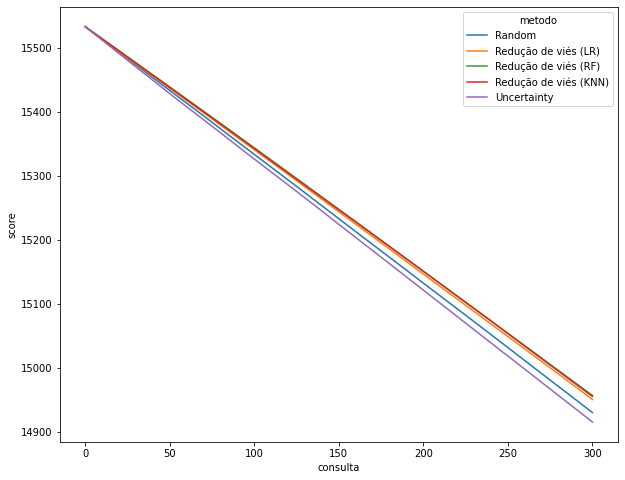

In [ ]:
plot_unc_br(air_results_unc_br, "airfoil_br_versus_unc_consulta")

In [ ]:
# novo kernel
from sklearn.gaussian_process.kernels import ConstantKernel
kernel =  1 * RBF(length_scale = 0.05, length_scale_bounds = (1e-20, 1e5)) 
our_models = [LinearRegression(), 
                 RandomForestRegressor(), 
                 KNeighborsRegressor()]
other_model = [uncertainty_regression_std]

In [ ]:
seed_amostras = 650
seed_processo = 950
n_amostra = 10
n_queries = 300
air_results_unc_br_2 = laco_GP(X_pool_air, y_pool_air, X_test_air, y_test_air,
            n_amostra, seed_amostras, seed_processo, 
            regressor = GaussianProcessRegressor(kernel=kernel), 
            our_methods = our_models, other_method = other_model, 
        n_queries = 300)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-20. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_re

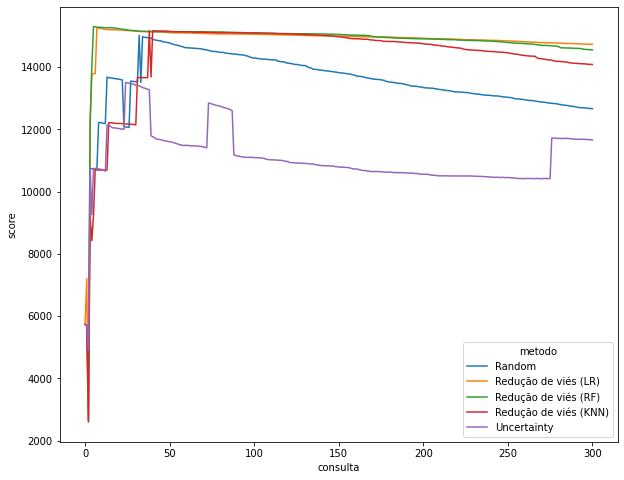

In [ ]:
plot_unc_br(air_results_unc_br_2, "airfoil_br_versus_unc_consulta_2")

### Bias reduction versus random sampling em modelos diferentes dos comuns

In [ ]:
seed_amostras = 850
seed_processo = 1050
n_amostra = 10
n_queries = 300
air_results_rand_br = laco_random(X_pool_air, y_pool_air, X_test_air, y_test_air,
                n_amostra, seed_amostras, seed_processo, 
                mods_list = our_models, n_queries = 300, n_initial = 30)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for i, x in enumerate(xi)]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for i, x in enumerate(xi)]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

<Figure size 864x576 with 0 Axes>

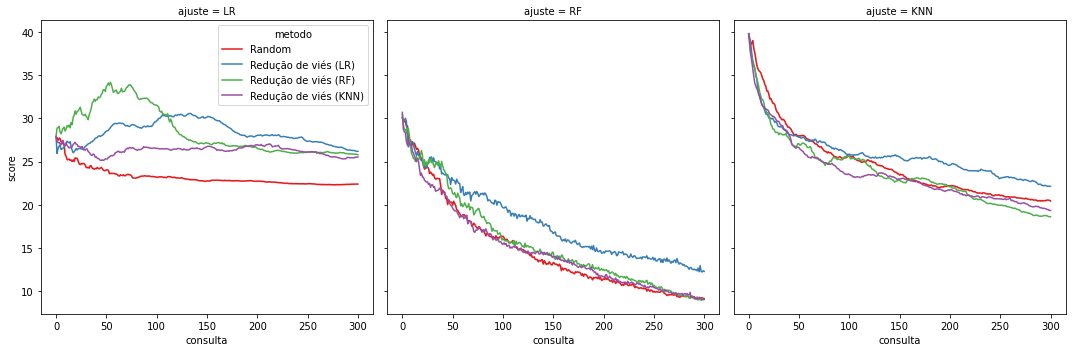

In [ ]:
plot_sim_random(air_results_rand_br, "airfoil_br_versus_random_consulta.pdf")

### Bias reduction versus QBC:

In [9]:
def mse_comp_ensemble(n_queries, X_train, y_train, X_pool, y_pool,
             X_test, y_test, methods, our_methods, other_method):
  all_methods = our_methods + other_method
  dici_mse = dict()
  model_list = []
  str1 = "Comite"
  learner_list = [ActiveLearner(
      estimator = method,
      X_training = X_train, y_training = y_train
  ) for method in methods]
  reg_mod_random = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy= random_sampling)
  
  list_rand = laco_modelo(n_queries, reg_mod_random, 
                          X_pool, y_pool, X_test, y_test)
  dici_mse[str1 + " " + "Random"] = list_rand
  committee = CommitteeRegressor(learner_list)
  for method in all_methods:
    if method in our_methods:
      reg_mod = ActiveLearner(estimator = committee,
                     query_strategy = bias_reduction,
                     X_training = X_train, y_training = y_train)
      
      list_mse = laco_modelo(n_queries, reg_mod, 
                          X_pool, y_pool, X_test, y_test, 
                          valid_regressor = method)
      # string da combinacao
      str2 = ''.join([c for c in str(method) if c.isupper()])
    else:
      learner_list = [ActiveLearner(
        estimator = method,
      X_training = X_train, y_training = y_train
      ) for method in methods]
      reg_mod = CommitteeRegressor(learner_list,
                                   query_strategy = method)
      list_mse = laco_modelo(n_queries, reg_mod, 
                          X_pool, y_pool, X_test, y_test)
      
      # string da combinacao
      str2 = ''.join(["Outro"])
    dici_mse[str1 + " " + str2] = list_mse
  return(dici_mse)

Métodos:

In [10]:
from sklearn.ensemble import BaggingRegressor
methods_list = [RandomForestRegressor(n_estimators = 150, max_depth = 5),
                 BaggingRegressor(n_estimators = 100),
                 KNeighborsRegressor(n_neighbors = 5)]

our_models = [LinearRegression(), 
              RandomForestRegressor(), 
              KNeighborsRegressor()]

other_method = [max_std_sampling]

Laço do QBC versus BR:

In [11]:
def laco_QBC(X_pool, y_pool, X_test, y_test, 
            n_amostra, seed_amostras, seed_processo, 
            methods = methods_list,our_methods = our_models,
            other_method = other_method, n_queries = 30,
            n_initial = 30):
  # gerando amostras de treino
  amostras = []
  sementes = gera_semente(seed = seed_amostras, reps = n_amostra)
  for i in range(len(sementes)):
    amostras.append(prepare_train(X_pool, y_pool, n_initial = n_initial, seed = sementes[i]))
  np.random.seed(seed_processo)
  # obtendo resultados de AL para cada amostra
  dfs = []
  for i in range(n_amostra):
    dici_conj = amostras[i]
    dici_ex = (mse_comp_ensemble(n_queries = n_queries, X_train = dici_conj["X_train"], y_train = dici_conj["y_train"], 
                    X_pool = dici_conj["X_pool"], y_pool = dici_conj["y_pool"], X_test = X_test, 
                    y_test = y_test, methods = methods_list, our_methods = our_models,
                    other_method = other_method))
    temp_data = create_sim_data_mods(dici_ex, metodo_comp = "QBC")
    temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
    dfs.append(temp_data)

  df = pd.concat(dfs, axis=0, ignore_index=True)
  # sim_ex2 = create_sim_data(dici_ex2)
  sim_ex = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'metodo': 'first'})
  return sim_ex

In [12]:
seed_amostras = 650
seed_processo = 950
n_amostra = 10
n_queries = 300
air_results_qbc_br= laco_QBC(X_pool_air, y_pool_air, X_test_air, y_test_air,
            n_amostra, seed_amostras, seed_processo, n_queries = 300)

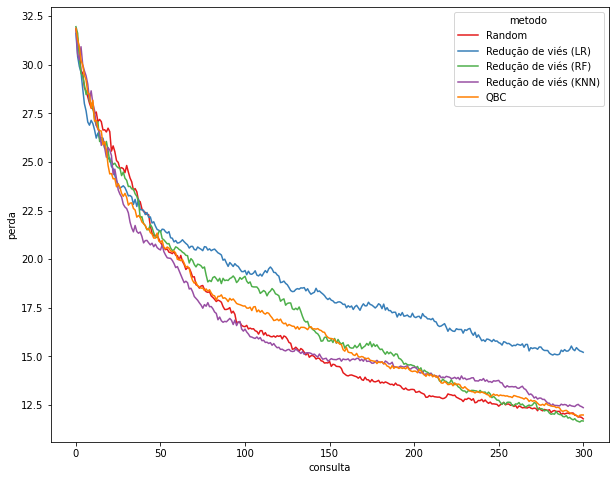

In [15]:
plot_unc_br(air_results_qbc_br, "air_qbc_versus_br_consultas.pdf")